In [1]:
# Our stuff:
import casclik as cc
import casadi as cs
# Plotting
from matplotlib import pyplot as plt
%matplotlib inline

# Simple 1-D Example: Moving cart

In this example we have a cart moving along a track, and we control the speed it has along the track.
Position of the cart along the track: $p(t)=\int_{\tau=0}^t\dot{p}(\tau)\mathrm{d}{\tau}$.

We will:
1. Move to a point, to learn the basics
2. Follow a trajectory, to see things work with a time dependence
3. Follow a path, to learn about virtual variables



In [2]:
t = cs.MX.sym("t") # Symbol for time 
p = cs.MX.sym("p") # Symbol for the cart point
dp = cs.MX.sym("dp") # Derivative of p

# WARNING!
# Animations take quite some time to create, and the code may stop for a couple of minutes at the animations
SHOW_ANIMATIONS = False

## Moving to a point

The point we want to move to is: $p_{des}$, which we'll call `p_des`. Let's say the track is from 0.0 to 1.0 m and we can move at a speed of at most 0.275 m/s (0.99 km/h) back and forth.
How about we try to move to a point along the track?

In [3]:
p_des = 0.75  # Desired point
max_speed = 0.275 # Max speed allowed in either direction
min_p = 0.0
max_p = 1.0

# Setup the constraint to get there
dist_to_point = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label="min_dist_cnstr", # Label for nice printing
    expression=dist_to_point, # Expression to be minimized
    gain=1.0, # Convergence gain
    constraint_type="soft", # The speed limit is hard, so this has to be soft to accommodate (sets whether to use slack)
    priority=1) # Priority when using pseudo inverse approaches

# Setup the cart length limits:
point = p
cart_limit_cnstr = cc.SetConstraint(
    label="cart_limit_cnstr",
    expression=point,
    gain=1.0,
    set_min=min_p,
    set_max=max_p)

# Setup the speed limits:
speed =  p
speed_limit_cnstr = cc.VelocitySetConstraint(
    label="speed_limit_cnstr",
    expression=speed,
    gain=10.0,
    set_min=-max_speed,
    set_max=max_speed)

point_skill = cc.SkillSpecification(
    label="move_to_point_skill", # Label for nice printing
    time_var=t, # the time var
    robot_var=p,
    robot_vel_var=dp, 
    constraints=[min_dist_cnstr, 
                 cart_limit_cnstr, 
                 speed_limit_cnstr])
point_skill.print_constraints() # Print some info about the constraints

SkillSpecification: move_to_point_skill
#0: min_dist_cnstr
#1: cart_limit_cnstr
#2: speed_limit_cnstr
Has virtual var: False
Has input var: False
N constraints: 3
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:1


### Reactive QP approach

In [4]:
# Create the controller:
reactiveQPcntrllr = cc.ReactiveQPController(
    skill_spec=point_skill, # The skill to execute
    robot_var_weights=[1.0]) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
reactiveQPcntrllr.setup_problem_functions() # This sets up the functions, compiles them
reactiveQPcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [5]:
%%timeit # Let's check the timing with some random points in the allowed range
test_initial = min_p + (max_p - min_p)*cs.np.random.rand()
reactiveQPcntrllr.solve(time_var=0.0, robot_var=test_initial)

10000 loops, best of 3: 78.8 µs per loop


In [6]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    dp_sim[i] = reactiveQPcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

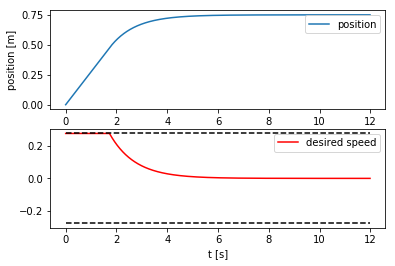

In [7]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

### Reactive NLP approach

In [8]:
# Create the controller:
reactiveNLPcntrllr = cc.ReactiveNLPController(
    skill_spec=point_skill,
    cost_expr=10.0*dp*dp) 
# The default cost expression with the NLP controller and MPC is robot_vel_var.T*robot_vel_var
# If you want something different, you can set it just as we did here
reactiveNLPcntrllr.setup_problem_functions()
reactiveNLPcntrllr.setup_solver()

In [9]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p -min_p)*cs.np.random.rand()
reactiveNLPcntrllr.solve(time_var=0.0, robot_var=test_initial)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

100 loops, best of 3: 3.24 ms per loop


In [10]:
#Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    dp_sim[i] = reactiveNLPcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

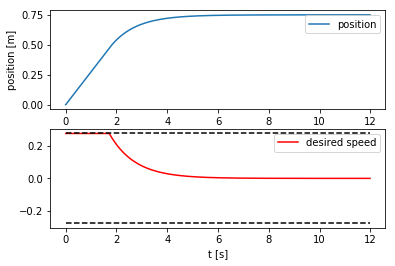

In [11]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

### Pseudo Inverse approach
The pseudo inverse controller does not have a way of handing VelocitySetConstraints. Perhaps I'll get around to figuring out a way of doing it in the future, but for now, we have to make a separate skill for this, where we also get the priorities right. Then we just saturate the velocity before applying it.
Note for programmers: sorting the constraints is just using the python method `sorted`, so you can make the priority key anything that can be compared if you want. 

In [12]:
# Modify the priority of the skills.
cart_limit_cnstr.priority = 1 # Moving out of the rail is the highest priority, we do not want to leave the rail
min_dist_cnstr.priority = 2 # Moving to the point is secondary, we should do it, but not at risk of leaving the rail
point_skill_pinv = cc.SkillSpecification(
    label="move_to_point_skill_pinv",
    time_var=t,
    robot_var=p,
    robot_vel_var=dp,
    constraints=[min_dist_cnstr, cart_limit_cnstr])
point_skill_pinv.print_constraints()

SkillSpecification: move_to_point_skill_pinv
#0: cart_limit_cnstr
#1: min_dist_cnstr
Has virtual var: False
Has input var: False
N constraints: 2
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:0


In [13]:
# Create the controller:
pseudoinvcntrllr = cc.PseudoInverseController(
    skill_spec=point_skill_pinv)
pseudoinvcntrllr.setup_problem_functions() # Does nothing in pseudoinversecontroller, but yeah, we'll remove it later
pseudoinvcntrllr.setup_solver() # Sets up everything

In [14]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p -min_p)*cs.np.random.rand()
pseudoinvcntrllr.solve(time_var=0.0, robot_var=test_initial)

The slowest run took 5.02 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 32.1 µs per loop


In [15]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    # Since we cannot do velocity set constraints, we must simulate them with speed saturation (max/min)
    dp_sim[i] = max(min(pseudoinvcntrllr.solve(t_sim[i], p_sim[i])[0].toarray(), max_speed), -max_speed)
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

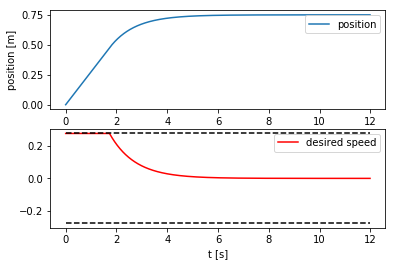

In [16]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

### Model predictive approach

In [17]:
# Create the controller:
mpcntrllr = cc.ModelPredictiveController(
    skill_spec=point_skill,
    cost_expr=1.0*dp*dp,
    timestep=dt,
    horizon_length=10)
# Here we must specify both the timestep and horizon_length. The timestep defaults to 0.01
# The horizon defaults to 5. The cost expression defaults to robot_vel_var.T*robot_vel_var
mpcntrllr.setup_problem_functions()
mpcntrllr.setup_solver()

In [18]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p -min_p)*cs.np.random.rand()
mpcntrllr.solve(time_var=0.0, robot_var=test_initial)

100 loops, best of 3: 7.14 ms per loop


In [19]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
dp_sim = cs.np.zeros(len(t_sim))
horizons_sim = []
for i in range(len(t_sim)-1):
    dp_sim[i] = mpcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    horizons_sim += [mpcntrllr.get_horizons()]

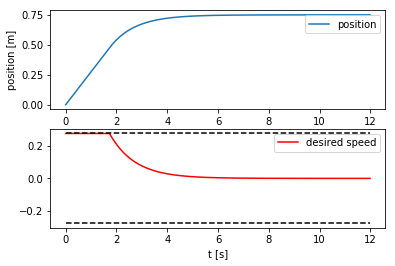

In [20]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

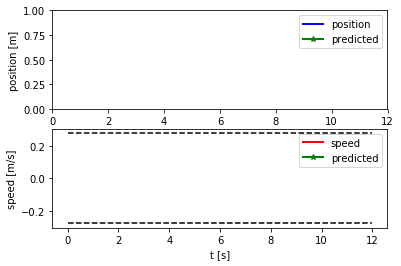

In [21]:
from matplotlib import animation
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(2,1)
realpos_line, = axs[0].plot([], [], lw=2,c="blue",label="position")
realspeed_line, = axs[1].plot([], [], lw=2, c="red",label="speed")
predpos_line, = axs[0].plot([],[], lw=2, c="g",marker="*", label="predicted")
predspeed_line, = axs[1].plot([],[], lw=2, c="g",marker="*", label="predicted")
axs[0].set_ylabel("position [m]")
axs[1].set_ylabel("speed [m/s]")
max_speed_line, = axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
min_speed_line, = axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[0].set_ylim([min_p, max_p])
axs[0].set_xlim([min(t_sim), max(t_sim)])

def init():
    realpos_line.set_data([],[])
    realspeed_line.set_data([],[])
    predpos_line.set_data([],[])
    predspeed_line.set_data([],[])
    axs[0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line]

def animate(i):
    realpos_line.set_data(t_sim[:i], p_sim[:i])
    realspeed_line.set_data(t_sim[:i],dp_sim[:i])
    pred_time = [t_sim[i] + j*dt for j in range(mpcntrllr.horizon_length)]
    predpos_line.set_data(pred_time, horizons_sim[i][0][1:])
    predspeed_line.set_data(pred_time, horizons_sim[i][1])
    # Growing limits
    #axs[0].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    #axs[1].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    # Moving window limits
    axs[0].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    axs[1].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    axs[0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line]
if SHOW_ANIMATIONS:
    anim_pos = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(t_sim)-1, interval=int(2000*dt), blit=True)
    html5_pos = anim_pos.to_html5_video()
else:
    html5_pos = None

In [22]:
HTML(html5_pos)

<IPython.core.display.HTML object>

## Tracking a trajectory
The trajectory we want to move to is: $p_{des}(t)$, which we'll call `p_des`, again. Let's say the track is from 0.0 to 1.0 m and we can move at a speed of at most 0.275 m/s (0.99 km/h) back and forth.
A simple example is a sine trajectory that goes out of the track. This is to really show those limits are there.
$$
p_{des}(t) = 0.4\sin(0.1t)
$$
We use the same cart and speed limits as before.

In [23]:
p_des = 0.4*cs.sin(0.3*t)  # Desired point

# Setup the constraint to get there
dist_to_traj = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label="min_dist_cnstr", # Label for nice printing
    expression=dist_to_traj, # Expression to be minimized
    gain=1.0, # Convergence gain
    constraint_type="soft", # The speed limit is hard, so this has to be soft to accommodate (sets whether to use slack)
    priority=1) # Priority when using pseudo inverse approaches

# Setup the cart length limits:
point = p
cart_limit_cnstr = cc.SetConstraint(
    label="cart_limit_cnstr",
    expression=point,
    gain=1.0,
    set_min=min_p,
    set_max=max_p)

# Setup the speed limits:
speed =  p
speed_limit_cnstr = cc.VelocitySetConstraint(
    label="speed_limit_cnstr",
    expression=speed,
    gain=10.0,
    set_min=-max_speed,
    set_max=max_speed)

trajectory_skill = cc.SkillSpecification(
    label="track_trajectory_skill", # Label for nice printing
    time_var=t, # the time var
    robot_var=p,
    robot_vel_var=dp, 
    constraints=[min_dist_cnstr, 
                 cart_limit_cnstr, 
                 speed_limit_cnstr])
trajectory_skill.print_constraints() # Print some info about the constraints

SkillSpecification: track_trajectory_skill
#0: min_dist_cnstr
#1: cart_limit_cnstr
#2: speed_limit_cnstr
Has virtual var: False
Has input var: False
N constraints: 3
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:1


### Reactive QP

In [24]:
# Create the controller:
reactiveQPcntrllr = cc.ReactiveQPController(
    skill_spec=trajectory_skill, # The skill to execute
    robot_var_weights=[1.0]) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
reactiveQPcntrllr.setup_problem_functions() # This sets up the functions, compiles them
reactiveQPcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [25]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
reactiveQPcntrllr.solve(time_var=0.0, robot_var=test_initial)#test_initial)

10000 loops, best of 3: 112 µs per loop


In [26]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
des_p_sim = [cs.Function("des_p",[t],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    dp_sim[i] = reactiveQPcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

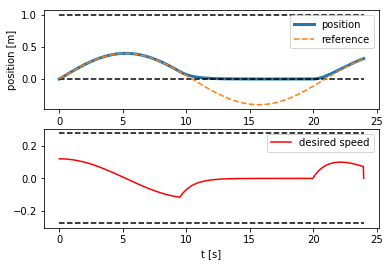

In [27]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

## Reactive NLP

In [28]:
# Create the controller:
reactiveNLPcntrllr = cc.ReactiveNLPController(
    skill_spec=trajectory_skill, # The skill to execute
    cost_expr=1.0*dp*dp) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
reactiveNLPcntrllr.setup_problem_functions() # This sets up the functions, compiles them
reactiveNLPcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [29]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
reactiveNLPcntrllr.solve(time_var=0.0, robot_var=test_initial)

100 loops, best of 3: 3.46 ms per loop


In [30]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
des_p_sim = [cs.Function("des_p",[t],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    dp_sim[i] = reactiveNLPcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

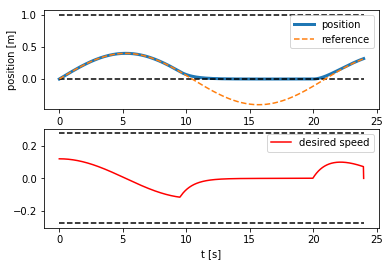

In [31]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

## Model Predictive approach

In [32]:
# Create the controller:
mpcntrllr = cc.ModelPredictiveController(
    skill_spec=trajectory_skill, # The skill to execute
    cost_expr=1.*dp*dp,
    timestep=dt, 
    horizon_length=10) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
mpcntrllr.setup_problem_functions() # This sets up the functions, compiles them
mpcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [33]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
mpcntrllr.solve(time_var=0.0, robot_var=test_initial)

100 loops, best of 3: 7.96 ms per loop


In [34]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
des_p_sim = [cs.Function("des_p",[t],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
horizons_sim = []
for i in range(len(t_sim)-1):
    dp_sim[i] = mpcntrllr.solve(t_sim[i], p_sim[i])[0].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    horizons_sim += [mpcntrllr.get_horizons()]

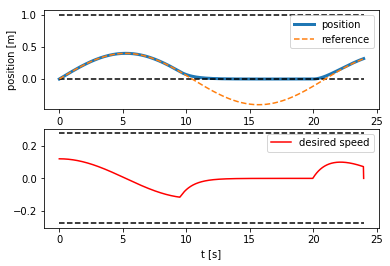

In [35]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

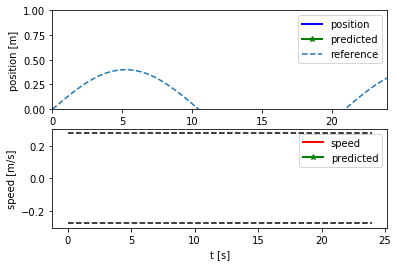

In [36]:
from matplotlib import animation
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(2,1)
realpos_line, = axs[0].plot([], [], lw=2,c="blue",label="position")
realspeed_line, = axs[1].plot([], [], lw=2, c="red",label="speed")
predpos_line, = axs[0].plot([],[], lw=2, c="g",marker="*", label="predicted")
predspeed_line, = axs[1].plot([],[], lw=2, c="g",marker="*", label="predicted")
reference_line, = axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].set_ylabel("speed [m/s]")
max_speed_line, = axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
min_speed_line, = axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[0].set_ylim([min_p, max_p])
axs[0].set_xlim([min(t_sim), max(t_sim)])

def init():
    realpos_line.set_data([],[])
    realspeed_line.set_data([],[])
    predpos_line.set_data([],[])
    predspeed_line.set_data([],[])
    axs[0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line]

def animate(i):
    realpos_line.set_data(t_sim[:i], p_sim[:i])
    realspeed_line.set_data(t_sim[:i],dp_sim[:i])
    pred_time = [t_sim[i] + j*dt for j in range(mpcntrllr.horizon_length)]
    predpos_line.set_data(pred_time, horizons_sim[i][0][1:])
    predspeed_line.set_data(pred_time, horizons_sim[i][1])
    # Growing limits
    #axs[0].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    #axs[1].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    # Moving window limits
    axs[0].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    axs[1].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    axs[0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line]
if SHOW_ANIMATIONS:
    anim_traj = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(t_sim)-1, interval=int(2000*dt), blit=True)
    html5_traj = anim_traj.to_html5_video()
else:
    html5_traj = None

In [37]:
HTML(html5_traj)

<IPython.core.display.HTML object>

## PseudoInverse approach
Same as previously, we don't have speed limits, so we have to fix some things

In [38]:
p_des = 0.4*cs.sin(0.3*t)  # Desired point

# Setup the constraint to get there
dist_to_traj = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label="min_dist_cnstr", # Label for nice printing
    expression=dist_to_traj, # Expression to be minimized
    gain=1.0, # Convergence gain
    priority=2) # Priority when using pseudo inverse approaches

# Setup the cart length limits:
point = p
cart_limit_cnstr = cc.SetConstraint(
    label="cart_limit_cnstr",
    expression=point,
    gain=1.0,
    set_min=min_p,
    set_max=max_p,
    priority=1)

trajectory_skill_pinv = cc.SkillSpecification(
    label="track_trajectory_skill_pinv", # Label for nice printing
    time_var=t, # the time var
    robot_var=p, # robot var
    robot_vel_var=dp,  # robot vel var
    constraints=[min_dist_cnstr, 
                 cart_limit_cnstr])
trajectory_skill_pinv.print_constraints() # Print some info about the constraints

SkillSpecification: track_trajectory_skill_pinv
#0: cart_limit_cnstr
#1: min_dist_cnstr
Has virtual var: False
Has input var: False
N constraints: 2
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:0


In [39]:
# Create the controller:
pseudoinvcntrllr = cc.PseudoInverseController(
    skill_spec=trajectory_skill_pinv)
pseudoinvcntrllr.setup_problem_functions() # Does nothing in pseudoinversecontroller, but yeah, we'll remove it later
pseudoinvcntrllr.setup_solver() # Sets up everything

In [40]:
%%timeit # Let's check the timing with some random points in the range
test_initial = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
pseudoinvcntrllr.solve(time_var=0.0, robot_var=0.001)#test_initial)

The slowest run took 4.80 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 32.7 µs per loop


In [41]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
des_p_sim = [cs.Function("des_p",[t],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    dp_sim[i] = max(min(pseudoinvcntrllr.solve(t_sim[i], p_sim[i])[0].toarray(),max_speed), -max_speed)
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt

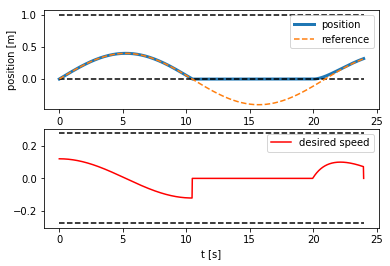

In [42]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()

## Path following
In this case we have a path rather than trajectory. Let's say the track is from 0.0 to 1.0 m and we can move at a speed of at most 0.275 m/s (0.99 km/h) back and forth. The path following variable is a virtual variable such that $x(t) = \int_{\tau=0}^{\tau=t}\dot{x}(t)$. And to ensure that we move along the track we add a soft constraint that $x-x_{f}=0$ 
A simple example is a sine path that goes out of the track to really show those limits are there.
$$
p_{des}(t) = 0.4\sin(0.3x)
$$

In [43]:
x = cs.MX.sym("x") # virtual var
dx = cs.MX.sym("dx") # virtual vel var
p_des = 0.4*cs.sin(0.3*x)  # Desired point

# Setup the constraint for the virtual var to converge to a large number
move_up_path = 300 - x
move_up_path_cnstr = cc.EqualityConstraint(
    label="move_up_path_cnstr",
    expression=move_up_path,
    gain=1.0,
    constraint_type="soft")

# But we don't want it to converge too fast, or it's better to just jump to the end.
max_dx = 1.1 # No faster than 110% the speed if it was a trajectory
min_dx = 0.0
slow_path_cnstr = cc.VelocitySetConstraint(
    label="slow_path_cnstr",
    expression=x,
    set_min=min_dx,
    set_max=max_dx)

# Setup the constraint to get there
dist_to_path = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label="min_dist_cnstr", # Label for nice printing
    expression=dist_to_path, # Expression to be minimized
    gain=1.0, # Convergence gain
    constraint_type="soft", # The speed limit is hard, so this has to be soft to accommodate (sets whether to use slack)
    priority=1) # Priority when using pseudo inverse approaches

# Setup the cart length limits:
point = p
cart_limit_cnstr = cc.SetConstraint(
    label="cart_limit_cnstr",
    expression=point,
    gain=1.0,
    set_min=min_p,
    set_max=max_p)

# Setup the speed limits:
speed =  p
speed_limit_cnstr = cc.VelocitySetConstraint(
    label="speed_limit_cnstr",
    expression=speed,
    gain=10.0,
    set_min=-max_speed,
    set_max=max_speed)

path_skill = cc.SkillSpecification(
    label="path_trajectory_skill", # Label for nice printing
    time_var=t, # the time var
    robot_var=p,
    robot_vel_var=dp, 
    virtual_var=x,
    virtual_vel_var=dx,
    constraints=[move_up_path_cnstr,
                 slow_path_cnstr,
                 min_dist_cnstr, 
                 cart_limit_cnstr, 
                 speed_limit_cnstr])
path_skill.print_constraints() # Print some info about the constraints

SkillSpecification: path_trajectory_skill
#0: move_up_path_cnstr
#1: slow_path_cnstr
#2: min_dist_cnstr
#3: cart_limit_cnstr
#4: speed_limit_cnstr
Has virtual var: True
Has input var: False
N constraints: 5
N equality:
	Pos:2	Vel:0
N set:
	Pos:1	Vel:2


## Reactive QP approach

In [44]:
# Create the controller:
reactiveQPcntrllr = cc.ReactiveQPController(
    skill_spec=path_skill, # The skill to execute
    robot_var_weights=[1.0]) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
reactiveQPcntrllr.setup_problem_functions() # This sets up the functions, compiles them
reactiveQPcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [45]:
%%timeit # Let's check the timing with some random points in the range
test_rob = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
test_virt = cs.np.random.rand()
reactiveQPcntrllr.solve(time_var=0.0, robot_var=test_rob, virtual_var=test_virt)

10000 loops, best of 3: 136 µs per loop


In [46]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
x_sim = cs.np.zeros(len(t_sim))
des_p_sim = [cs.Function("des_p",[x],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
dx_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    res = reactiveQPcntrllr.solve(t_sim[i], p_sim[i], x_sim[i])
    dp_sim[i] = res[0].toarray()
    dx_sim[i] = res[1].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    x_sim[i+1] = x_sim[i] + dx_sim[i]*dt

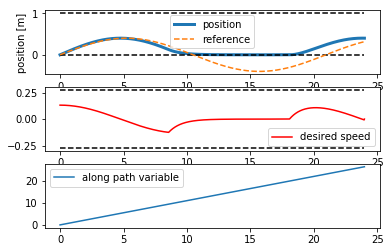

In [47]:
fig, axs = plt.subplots(3,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[2].plot(t_sim, x_sim,label="along path variable")
axs[2].legend()

## Reactive NLP Approach

In [48]:
# Create the controller:
reactiveNLPcntrllr = cc.ReactiveNLPController(
    skill_spec=path_skill, # The skill to execute
    cost_expr=1.0*dp*dp) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
reactiveNLPcntrllr.setup_problem_functions() # This sets up the functions, compiles them
reactiveNLPcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [49]:
%%timeit # Let's check the timing with some random points in the range
test_rob = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
test_virt = cs.np.random.rand()
reactiveNLPcntrllr.solve(time_var=0.0, robot_var=test_rob, virtual_var=test_virt)

100 loops, best of 3: 4.5 ms per loop


In [50]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
x_sim = cs.np.zeros(len(t_sim))
des_p_sim = [cs.Function("des_p",[x],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
dx_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    res = reactiveNLPcntrllr.solve(t_sim[i], p_sim[i], x_sim[i])
    dp_sim[i] = res[0].toarray()
    dx_sim[i] = res[1].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    x_sim[i+1] = x_sim[i] + dx_sim[i]*dt

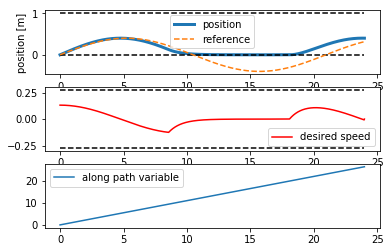

In [51]:
fig, axs = plt.subplots(3,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[2].plot(t_sim, x_sim, label="along path variable")
axs[2].legend()

## Model predictive approach

In [52]:
# Create the controller:
mpcntrllr = cc.ModelPredictiveController(
    skill_spec=path_skill, # The skill to execute
    cost_expr=1.*dp*dp,
    timestep=dt,
    horizon_length=10) # The weights in the QP, defaults to 1.0
# Setup the things in the controller:
mpcntrllr.setup_problem_functions() # This sets up the functions, compiles them
mpcntrllr.setup_solver() # This sets up the solver itself
# Eventually these two will be combined

In [53]:
%%timeit # Let's check the timing with some random points in the range
test_rob = min_p + (max_p - min_p-1e-5)*cs.np.random.rand() + 1e-6
test_virt = cs.np.random.rand()
mpcntrllr.solve(time_var=0.0, robot_var=test_rob, virtual_var=test_virt)

100 loops, best of 3: 12.2 ms per loop


In [54]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
x_sim = cs.np.zeros(len(t_sim))
des_p_sim = [cs.Function("des_p",[x],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
dx_sim = cs.np.zeros(len(t_sim))
horizons_sim = []
for i in range(len(t_sim)-1):
    res = mpcntrllr.solve(t_sim[i], p_sim[i], x_sim[i])
    dp_sim[i] = res[0].toarray()
    dx_sim[i] = res[1].toarray()
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    x_sim[i+1] = x_sim[i] + dx_sim[i]*dt
    horizons_sim += [mpcntrllr.get_horizons()]

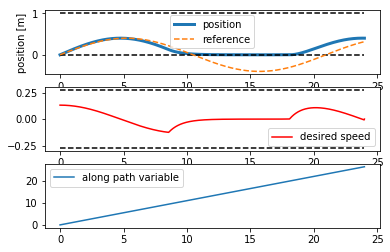

In [55]:
fig, axs = plt.subplots(3,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[2].plot(t_sim, x_sim, label="along path variable")
axs[2].legend()

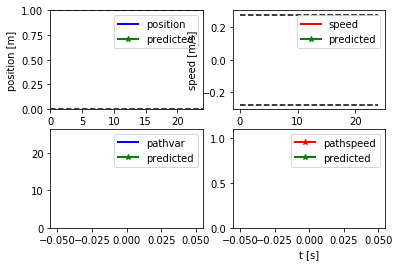

In [56]:
from matplotlib import animation
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(2,2)

realpos_line, = axs[0][0].plot([], [], lw=2,c="blue",label="position")
predpos_line, = axs[0][0].plot([],[], lw=2, c="g",marker="*", label="predicted")
realspeed_line, = axs[0][1].plot([], [], lw=2, c="red",label="speed")
predspeed_line, = axs[0][1].plot([],[], lw=2, c="g",marker="*", label="predicted")
axs[0][0].set_ylabel("position [m]")
axs[0][1].set_ylabel("speed [m/s]")
max_pos_line, = axs[0][0].plot([min(t_sim),max(t_sim)],[max_p,max_p],'k--')
min_pos_line, = axs[0][0].plot([min(t_sim),max(t_sim)],[min_p,min_p],'k--')
max_speed_line, = axs[0][1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
min_speed_line, = axs[0][1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[0][1].set_xlabel("t [s]")
axs[0][0].legend()
axs[0][1].legend()
axs[0][0].set_ylim([min_p, max_p])
axs[0][0].set_xlim([min(t_sim), max(t_sim)])

realpathvar_line, = axs[1][0].plot([], [], lw=2, c="blue", label="pathvar")
predpathvar_line, = axs[1][0].plot([], [], lw=2, c="g", marker="*", label="predicted")
realpathspeed_line, = axs[1][1].plot([], [], lw=2, c="red", marker="*", label="pathspeed")
predpathspeed_line, = axs[1][1].plot([], [], lw=2, c="g", marker="*", label="predicted")
axs[1][1].set_xlabel("t [s]")
axs[1][0].legend()
axs[1][1].legend()
axs[1][0].set_ylim([min(x_sim), max(x_sim)])
axs[1][1].set_ylim([min_dx, max_dx])

def init():
    realpos_line.set_data([],[])
    realspeed_line.set_data([],[])
    predpos_line.set_data([],[])
    predspeed_line.set_data([],[])
    realpathvar_line.set_data([], [])
    realpathspeed_line.set_data([], [])
    predpathvar_line.set_data([], [])
    predpathspeed_line.set_data([], [])
    axs[0][0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line,
            realpathvar_line, realpathspeed_line, predpathvar_line, predpathspeed_line]

def animate(i):
    realpos_line.set_data(t_sim[:i], p_sim[:i])
    realspeed_line.set_data(t_sim[:i],dp_sim[:i])
    realpathvar_line.set_data(t_sim[:i], x_sim[:i])
    realpathspeed_line.set_data(t_sim[:i], dx_sim[:i])
    pred_time = [t_sim[i] + j*dt for j in range(mpcntrllr.horizon_length)]
    predpos_line.set_data(pred_time, horizons_sim[i][0][1:])
    predspeed_line.set_data(pred_time, horizons_sim[i][1])
    predpathvar_line.set_data(pred_time, horizons_sim[i][2][1:])
    predpathspeed_line.set_data(pred_time, horizons_sim[i][3])
    # Growing limits
    axs[0][0].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    axs[0][1].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    axs[1][0].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    axs[1][1].set_xlim([min(t_sim), max(pred_time) + 5*dt])
    # Moving window limits
    #axs[0][0].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    #axs[0][1].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    #axs[1][0].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    #axs[1][1].set_xlim([t_sim[i]-20*dt, t_sim[i]+(mpcntrllr.horizon_length+10)*dt])
    #axs[0][0].set_title("Timestep:"+str(i))
    return [realpos_line, realspeed_line, predpos_line, predspeed_line,
            realpathvar_line, realpathspeed_line, predpathvar_line, predpathspeed_line]
if SHOW_ANIMATIONS:
    anim_path = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(t_sim)-1, interval=int(2000*dt), blit=True)
    html5_path = anim_path.to_html5_video()
else:
    html5_path = None

In [57]:
HTML(html5_path)

<IPython.core.display.HTML object>

## Pseudo inverse approach
As always, we have to change things a little.

In [58]:
x = cs.MX.sym("x") # virtual var
dx = cs.MX.sym("dx") # virtual vel var
p_des = 0.4*cs.sin(0.3*x)  # Desired point

# Setup the constraint for the virtual var to converge to a large number
move_up_path = 300 - x
move_up_path_cnstr = cc.EqualityConstraint(
    label="move_up_path_cnstr",
    expression=move_up_path,
    gain=1.0,
    priority=1)

# Setup the constraint to get there
dist_to_path = p_des - p
min_dist_cnstr = cc.EqualityConstraint(
    label="min_dist_cnstr", # Label for nice printing
    expression=dist_to_path, # Expression to be minimized
    gain=1.0, # Convergence gain
    constraint_type="soft", # The speed limit is hard, so this has to be soft to accommodate (sets whether to use slack)
    priority=3) # Priority when using pseudo inverse approaches

# Setup the cart length limits:
point = p
cart_limit_cnstr = cc.SetConstraint(
    label="cart_limit_cnstr",
    expression=point,
    gain=1.0,
    set_min=min_p,
    set_max=max_p,
    priority=1)

path_skill_pinv = cc.SkillSpecification(
    label="path_trajectory_skill", # Label for nice printing
    time_var=t, # the time var
    robot_var=p,
    robot_vel_var=dp, 
    virtual_var=x,
    virtual_vel_var=dx,
    constraints=[move_up_path_cnstr,
                 min_dist_cnstr, 
                 cart_limit_cnstr])
path_skill_pinv.print_constraints() # Print some info about the constraints

SkillSpecification: path_trajectory_skill
#0: move_up_path_cnstr
#1: cart_limit_cnstr
#2: min_dist_cnstr
Has virtual var: True
Has input var: False
N constraints: 3
N equality:
	Pos:2	Vel:0
N set:
	Pos:1	Vel:0


In [59]:
# Create the controller:
pseudoinvcntrllr = cc.PseudoInverseController(
    skill_spec=path_skill_pinv)
pseudoinvcntrllr.setup_problem_functions() # Does nothing in pseudoinversecontroller, but yeah, we'll remove it later
pseudoinvcntrllr.setup_solver() # Sets up everything

In [60]:
# Simulate it!
dt = 0.02
t_sim = cs.np.array([dt*i for i in range(1200)])
p_sim = cs.np.zeros(len(t_sim))
p_sim[0] = 0.0001
x_sim = cs.np.zeros(len(t_sim))
des_p_sim = [cs.Function("des_p",[x],[p_des])(t_sim[i]) for i in range(len(t_sim))]
dp_sim = cs.np.zeros(len(t_sim))
dx_sim = cs.np.zeros(len(t_sim))
for i in range(len(t_sim)-1):
    res = pseudoinvcntrllr.solve(t_sim[i], p_sim[i], x_sim[i])
    dp_sim[i] = max(min(res[0].toarray(), max_speed), -max_speed)
    dx_sim[i] = max(min(res[1].toarray(), max_dx), min_dx)
    p_sim[i+1] = p_sim[i] + dp_sim[i]*dt
    x_sim[i+1] = x_sim[i] + dx_sim[i]*dt

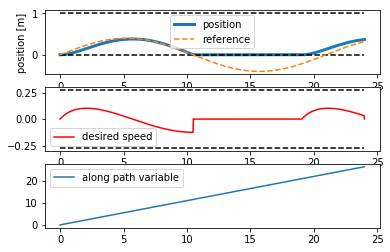

In [61]:
fig, axs = plt.subplots(3,1)
axs[0].plot(t_sim, p_sim, label="position",lw=3)
axs[0].plot([min(t_sim),max(t_sim)],[min_p,min_p],"k--")
axs[0].plot([min(t_sim),max(t_sim)],[max_p,max_p],"k--")
axs[0].plot(t_sim, des_p_sim,label="reference",ls="--")
axs[0].set_ylabel("position [m]")
axs[1].plot(t_sim, dp_sim, label="desired speed",c="r")
axs[1].plot([min(t_sim),max(t_sim)],[max_speed, max_speed],'k--')
axs[1].plot([min(t_sim),max(t_sim)],[-max_speed, -max_speed],'k--')
axs[1].set_xlabel("t [s]")
axs[0].legend()
axs[1].legend()
axs[2].plot(t_sim, x_sim, label="along path variable")
axs[2].legend()

## Conclusions
When we don't change the cost function, and there's not much future information to exploit in any meaningful way, there is little to no difference between the the optimization-based approaches. The pseudoinverse approach has a hard switching between modes. This causes the sharp shifts we can see in the desired speed when it approaches a set constraint. All formulations can handle positioning, tracking, and path tasks quite easily. 

Note the execution times of the four different controllers. Generally we can expect PINV < QP < NLP < MPC, with pseudo-inverse taking 1/10th of the time of QP, QP taking 1/10th the time of NLP etc.
This execution time is a consideration for the real-time applicability of the different controller scenarios. However, this is just with the standard tunings. One may still be able to improve the execution time if one uses a different NLP solver, or starts tuning its parameters.